In [1]:
# ============================================================
# Block 1: Imports & Setup
# ============================================================
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, roc_auc_score, f1_score,
                             roc_curve, auc, precision_recall_curve, accuracy_score,
                             confusion_matrix)

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

np.random.seed(42)


In [2]:
# ============================================================
# Block 2: Generate Training Data
# ============================================================
n_train = 10000
cust_ids = [f"CUST{str(i).zfill(6)}" for i in range(1, n_train+1)]
agent_ids = [f"AGT{str(i).zfill(3)}" for i in range(1, 21)]  # only 20 agents

# Dates
call_dates = [datetime(2025,7,1) + timedelta(days=random.randint(0,30)) for _ in range(n_train)]
signup_dates = [d - timedelta(days=random.randint(30, 1000)) for d in call_dates]

train = pd.DataFrame({
    "CustomerID": cust_ids,
    "SignupDate": signup_dates,
    "CallDate": call_dates,
    "Region": np.random.choice(["Urban","Semi-Urban","Rural"], n_train, p=[0.5,0.3,0.2]),
    "PlanType": np.random.choice(["Postpaid","Prepaid"], n_train, p=[0.7,0.3]),
    "DeviceType": np.random.choice(["iOS","Android","Feature Phone"], n_train, p=[0.3,0.6,0.1]),
    "MonthlyBillAmount": np.round(np.random.uniform(200,3000, size=n_train),2),
    "MonthlyUsageVoice": np.random.poisson(lam=200, size=n_train),
    "MonthlyUsageData": np.round(np.random.gamma(2,2, size=n_train),2),
    "DaysInArrears": np.random.randint(0,90,n_train),
    "OutstandingAmount": np.round(np.random.uniform(100,8000, size=n_train),2),
    "PastLatePaymentsCount": np.random.poisson(2, n_train),
    "PreferredContactHour": np.random.randint(0,24,n_train),
    "NumCallsLast30Days": np.random.randint(0,5,n_train),
    "NumEmailsLast30Days": np.random.randint(0,5,n_train),
    "NumSMSLast30Days": np.random.randint(0,5,n_train),
    "AgentID": np.random.choice(agent_ids,n_train),
    "AgentExperienceYears": np.random.randint(1,15,n_train),
    "AgentPerformanceScore": np.round(np.random.uniform(2.5,5.0,n_train),2)
})

# Derived
train["TenureMonths"] = ((train["CallDate"] - train["SignupDate"]).dt.days/30).astype(int).clip(lower=1)

# Target Paid/Unpaid
def simulate_payment(row):
    p = 0.4
    if row["DaysInArrears"] < 10: p += 0.25
    if row["OutstandingAmount"] < 1000: p += 0.2
    if row["PastLatePaymentsCount"] > 3: p -= 0.2
    return "Paid" if np.random.rand()<p else "Unpaid"

train["PaymentStatus"] = train.apply(simulate_payment, axis=1)

# Contact window labels
train["BestCallWindow"] = train["PreferredContactHour"].apply(
    lambda h: "Morning" if h<12 else ("Afternoon" if h<18 else "Evening")
)


In [3]:
# ============================================================
# Block 3: Generate Daily Test Data (arrears only, no target)
# ============================================================
n_test = 1000
test = train.sample(n_test, replace=False).drop(columns=["PaymentStatus"])
test["CallDate"] = datetime(2025,8,1)


[LightGBM] [Info] Number of positive: 2894, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.413429 -> initscore=-0.349810
[LightGBM] [Info] Start training from score -0.349810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

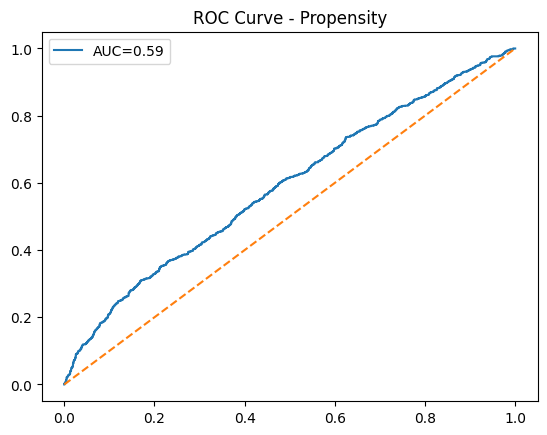

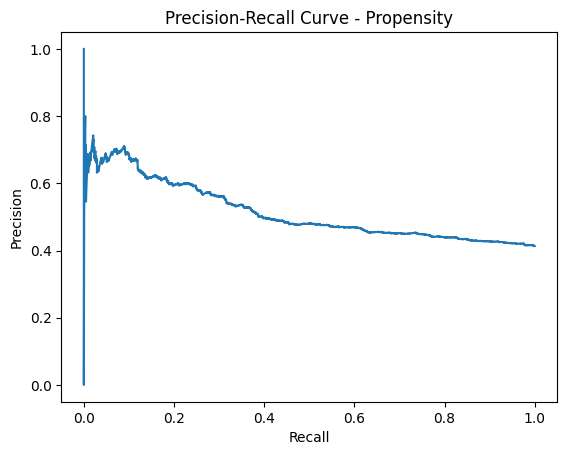

In [4]:
# ============================================================
# Block 4: Propensity-to-Pay Model
# ============================================================
cat_cols = ["Region","PlanType","DeviceType","BestCallWindow","AgentID"]
train_enc = train.copy()
test_enc = test.copy()
for c in cat_cols:
    le = LabelEncoder()
    train_enc[c] = le.fit_transform(train_enc[c].astype(str))
    test_enc[c] = le.transform(test_enc[c].astype(str))

features_ptp = ["TenureMonths","MonthlyBillAmount","OutstandingAmount","DaysInArrears",
                "PastLatePaymentsCount","Region","PlanType","MonthlyUsageVoice","MonthlyUsageData",
                "NumCallsLast30Days","NumEmailsLast30Days","NumSMSLast30Days"]

X = train_enc[features_ptp]
y = (train_enc["PaymentStatus"]=="Paid").astype(int)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

model_ptp = lgb.LGBMClassifier(n_estimators=400,max_depth=8,learning_rate=0.05,random_state=42)
model_ptp.fit(X_train,y_train)

y_val_pred = model_ptp.predict(X_val)
y_val_proba = model_ptp.predict_proba(X_val)[:,1]

print("=== Propensity to Pay ===")
print("Accuracy:", accuracy_score(y_val,y_val_pred))
print("F1 Score:", f1_score(y_val,y_val_pred))
print("ROC AUC:", roc_auc_score(y_val,y_val_proba))
print(classification_report(y_val,y_val_pred))

# ROC curve
fpr,tpr,_ = roc_curve(y_val,y_val_proba)
plt.figure(); plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_val,y_val_proba):.2f}")
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.title("ROC Curve - Propensity"); plt.show()

# PR curve
prec,recall,_ = precision_recall_curve(y_val,y_val_proba)
plt.figure(); plt.plot(recall,prec); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Propensity"); plt.show()

# Predict on test
test_enc["PropensityScore"] = model_ptp.predict_proba(test_enc[features_ptp])[:,1]
def segment(p): return "High" if p>0.7 else ("Medium" if p>=0.4 else "Low")
test_enc["Segment"] = test_enc["PropensityScore"].apply(segment)
treatment_map = {"High":"Send SMS+Email","Medium":"Phone Call + SMS","Low":"Escalate to Supervisor"}
test_enc["Treatment"] = test_enc["Segment"].map(treatment_map)


=== Best Time to Call ===
Accuracy: 0.49333333333333335
F1 Score: 0.3302439224447514
              precision    recall  f1-score   support

           0       0.14      0.00      0.00       758
           1       0.50      0.01      0.02       763
           2       0.49      1.00      0.66      1479

    accuracy                           0.49      3000
   macro avg       0.38      0.34      0.23      3000
weighted avg       0.41      0.49      0.33      3000



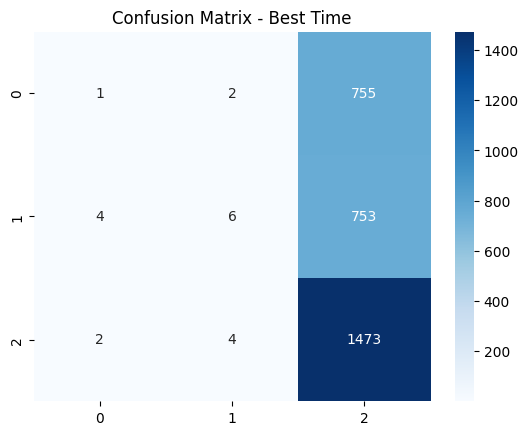

In [5]:
# ============================================================
# Block 5: Best Time to Call Model
# ============================================================
features_btc = ["Region","PlanType","NumCallsLast30Days","NumSMSLast30Days",
                "DaysInArrears","OutstandingAmount","MonthlyUsageVoice","MonthlyUsageData"]

X2 = train_enc[features_btc]
y2 = train_enc["BestCallWindow"]
X2_train,X2_val,y2_train,y2_val = train_test_split(X2,y2,test_size=0.3,random_state=42,stratify=y2)

model_btc = RandomForestClassifier(n_estimators=300,max_depth=10,random_state=42)
model_btc.fit(X2_train,y2_train)
y2_val_pred = model_btc.predict(X2_val)

print("=== Best Time to Call ===")
print("Accuracy:", accuracy_score(y2_val,y2_val_pred))
print("F1 Score:", f1_score(y2_val,y2_val_pred,average="weighted"))
print(classification_report(y2_val,y2_val_pred))

cm = confusion_matrix(y2_val,y2_val_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=model_btc.classes_,yticklabels=model_btc.classes_)
plt.title("Confusion Matrix - Best Time"); plt.show()

# Predict on test
test_enc["PredictedBestCallWindow"] = model_btc.predict(test_enc[features_btc])


In [6]:
# ============================================================
# Block 6: Agent Assignment Model
# ============================================================
features_agent = ["Region","PlanType","OutstandingAmount","DaysInArrears","MonthlyBillAmount",
                  "MonthlyUsageVoice","MonthlyUsageData","AgentExperienceYears","AgentPerformanceScore"]

X3 = train_enc[features_agent]
y3 = train_enc["AgentID"]
X3_train,X3_val,y3_train,y3_val = train_test_split(X3,y3,test_size=0.3,random_state=42,stratify=y3)

model_agent = RandomForestClassifier(n_estimators=300,max_depth=12,random_state=42)
model_agent.fit(X3_train,y3_train)
y3_val_pred = model_agent.predict(X3_val)

print("=== Agent Assignment ===")
print("Accuracy:", accuracy_score(y3_val,y3_val_pred))
print("F1 Score:", f1_score(y3_val,y3_val_pred,average="weighted"))
print(classification_report(y3_val,y3_val_pred))

# Predict on test
test_enc["PredictedAgentID"] = model_agent.predict(test_enc[features_agent])


=== Agent Assignment ===
Accuracy: 0.052
F1 Score: 0.04869715842038979
              precision    recall  f1-score   support

           0       0.05      0.08      0.06       156
           1       0.03      0.03      0.03       156
           2       0.03      0.03      0.03       150
           3       0.08      0.12      0.10       157
           4       0.05      0.06      0.06       151
           5       0.05      0.05      0.05       149
           6       0.05      0.05      0.05       155
           7       0.02      0.01      0.02       144
           8       0.07      0.06      0.07       146
           9       0.05      0.03      0.03       143
          10       0.04      0.05      0.05       156
          11       0.03      0.03      0.03       155
          12       0.02      0.01      0.02       143
          13       0.04      0.03      0.03       149
          14       0.05      0.03      0.04       143
          15       0.06      0.05      0.06       150
          

In [7]:
# ============================================================
# Block 7: Inference Pipeline – Final Combined Output
# ============================================================
final_results = test_enc[["CustomerID","PropensityScore","Segment","Treatment",
                          "PredictedBestCallWindow","PredictedAgentID","OutstandingAmount"]]

final_results.to_csv("final_daily_predictions.csv",index=False)
print("✅ Final combined predictions saved to final_daily_predictions.csv")
print(final_results.head(15))


✅ Final combined predictions saved to final_daily_predictions.csv
      CustomerID  PropensityScore Segment               Treatment  \
2697  CUST002698         0.324704     Low  Escalate to Supervisor   
6326  CUST006327         0.868737    High          Send SMS+Email   
1289  CUST001290         0.795586    High          Send SMS+Email   
1106  CUST001107         0.087301     Low  Escalate to Supervisor   
9222  CUST009223         0.195582     Low  Escalate to Supervisor   
8696  CUST008697         0.392221     Low  Escalate to Supervisor   
5583  CUST005584         0.383631     Low  Escalate to Supervisor   
1048  CUST001049         0.617571  Medium        Phone Call + SMS   
2939  CUST002940         0.893456    High          Send SMS+Email   
7912  CUST007913         0.596148  Medium        Phone Call + SMS   
4357  CUST004358         0.189048     Low  Escalate to Supervisor   
8066  CUST008067         0.493783  Medium        Phone Call + SMS   
3644  CUST003645         0.407670  Me

/tmp/ipython-input-3598759770.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Segment", data=final_results, order=["High","Medium","Low"], palette="Set2")


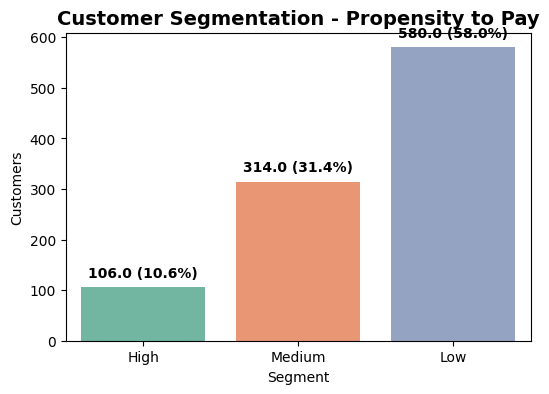

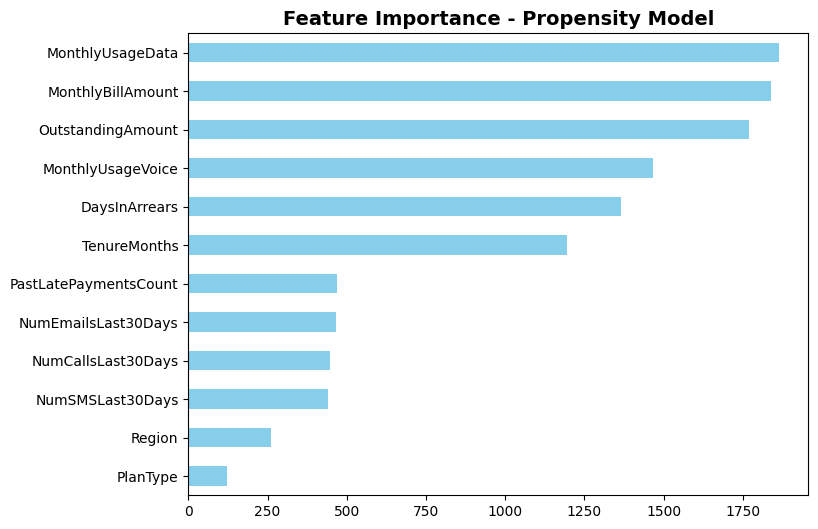

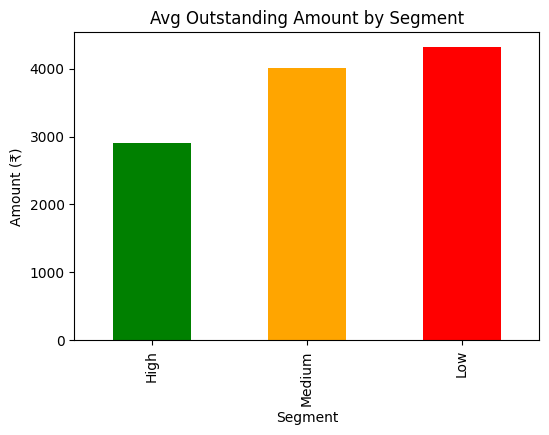

In [8]:
# ============================================================
# Block 8: Visualization for PPT
# ============================================================

# --- Segment distribution ---
plt.figure(figsize=(6,4))
ax = sns.countplot(x="Segment", data=final_results, order=["High","Medium","Low"], palette="Set2")
plt.title("Customer Segmentation - Propensity to Pay", fontsize=14, fontweight="bold")
plt.xlabel("Segment"); plt.ylabel("Customers")

total = len(final_results)
for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, h+20, f"{h} ({100*h/total:.1f}%)", ha="center", fontsize=10, fontweight="bold")
plt.show()

# --- Feature importance ---
importances = pd.Series(model_ptp.feature_importances_, index=features_ptp).sort_values()
plt.figure(figsize=(8,6))
importances.plot(kind="barh", color="skyblue")
plt.title("Feature Importance - Propensity Model", fontsize=14, fontweight="bold")
plt.show()

# --- Avg Outstanding by Segment ---
seg_summary = final_results.groupby("Segment")["OutstandingAmount"].mean().reindex(["High","Medium","Low"])
plt.figure(figsize=(6,4))
seg_summary.plot(kind="bar", color=["green","orange","red"])
plt.title("Avg Outstanding Amount by Segment")
plt.ylabel("Amount (₹)")
plt.show()


In [14]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from datetime import datetime
import joblib

# --------------------------------------------------
# Load Pretrained Models + Encoders
# --------------------------------------------------
model_ptp = joblib.load("propensity_model.pkl")
model_btc = joblib.load("besttime_model.pkl")
model_agent = joblib.load("agent_model.pkl")
encoders = joblib.load("encoders.pkl")
features_ptp = joblib.load("features_ptp.pkl")
features_btc = joblib.load("features_btc.pkl")
features_agent = joblib.load("features_agent.pkl")

st.set_page_config(page_title="AT&T Collections AI", layout="wide")
st.title("📊 AT&T Spirit Hackathon – Collections AI Assistant")

uploaded_file = st.sidebar.file_uploader("Upload arrears CSV", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.subheader("📥 Uploaded Data Preview")
    st.dataframe(df.head())

    df_enc = df.copy()
    for c, le in encoders.items():
        if c in df_enc.columns:
            df_enc[c] = le.transform(df_enc[c].astype(str))

    df_enc["PropensityScore"] = model_ptp.predict_proba(df_enc[features_ptp])[:,1]

    def segment(p):
        return "High" if p > 0.7 else ("Medium" if p >= 0.4 else "Low")
    df_enc["Segment"] = df_enc["PropensityScore"].apply(segment)

    treatment_map = {"High":"Send SMS+Email",
                     "Medium":"Phone Call + SMS",
                     "Low":"Escalate to Supervisor"}
    df_enc["Treatment"] = df_enc["Segment"].map(treatment_map)

    df_enc["PredictedBestCallWindow"] = model_btc.predict(df_enc[features_btc])
    df_enc["PredictedAgentID"] = model_agent.predict(df_enc[features_agent])

    final_results = df_enc[["CustomerID","PropensityScore","Segment","Treatment",
                            "PredictedBestCallWindow","PredictedAgentID","OutstandingAmount"]]

    st.subheader("✅ Final Predictions")
    st.dataframe(final_results)

    st.download_button(
        label="📥 Download Final Predictions",
        data=final_results.to_csv(index=False).encode("utf-8"),
        file_name=f"daily_predictions_{datetime.today().strftime('%Y%m%d')}.csv",
        mime="text/csv"
    )


Overwriting app.py


In [10]:
pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.6 MB/s eta 0:00:00


In [17]:
!pip install pyngrok -q

from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

# Run Streamlit in the background
get_ipython().system_raw('streamlit run app.py --server.port 8501 &')

# Create new tunnel
public_url = ngrok.connect(8501)
print("✅ Streamlit is live! Click this URL:\n", public_url)


ERROR:pyngrok.process.ngrok:t=2025-09-17T21:06:36+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-17T21:06:36+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-09-17T21:06:36+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [15]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.59.134:8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦your url is: https://busy-feet-stay.loca.lt
103.210.134.64
  Stopping...
^C
